## Imports

In [1]:
import os
current_file_dir = os.getcwd()
os.chdir("../../codes/")

from src.load_explanations import load_explanations_of_many_models, _unify_lenths, _trim_image_path
from src import strings_to_classes_mappings

from src.compare_explanations import compare_explanations, cosine_similarity_distance_with_stdev_and_mean, radial_basis_function_distance_with_stdev_and_mean, cosine_similarity, radial_basis_function
from src.load_explanations import load_explanations_of_many_models

os.chdir(current_file_dir)

# Usage example

Get possible models etc.

In [2]:
print("Possible datasets:", list(strings_to_classes_mappings.datasets_mapping.keys()))
print("Possible models:", list(strings_to_classes_mappings.models_mapping.keys()))
print("Possible explanations:", list(strings_to_classes_mappings.explanations_mapping.keys()))
models_list = list(strings_to_classes_mappings.models_mapping.keys())

Possible datasets: ['imagenette2']
Possible models: ['ConvNeXtV2_Nano', 'DeiT_S', 'DeiT_T', 'DenseNet121', 'EfficientNet_B3', 'EfficientNet_B4', 'MobileNetV3', 'PyramidViT_V2_B2', 'Res2Net50', 'ResNet18', 'ResNet50', 'ResNeXt50', 'Swin_T', 'ViT_B_32']
Possible explanations: ['GradCAM', 'IntegratedGradients', 'KernelSHAP']


# Getting data

In [3]:
paths_to_explanations = {
    "GradCAM" : os.path.join(current_file_dir, os.pardir, "20240620-gradcam-kernelshap-ig-128"),
    "KernelSHAP" : os.path.join(current_file_dir, os.pardir, "20240620-gradcam-kernelshap-ig-128"),
    "IntegratedGradients" : os.path.join(current_file_dir, os.pardir, "20240620-gradcam-kernelshap-ig-128"),
}

In [4]:
explanations_many_models_i = load_explanations_of_many_models('imagenette2', models_list, 'IntegratedGradients', root_explanations=paths_to_explanations['IntegratedGradients'])
explanations_many_models_k = load_explanations_of_many_models('imagenette2', models_list, 'KernelSHAP', root_explanations=paths_to_explanations['KernelSHAP'])
explanations_many_models_g = load_explanations_of_many_models('imagenette2', models_list, 'GradCAM', root_explanations=paths_to_explanations['GradCAM'])

Loading explanations: 100%|██████████| 128/128 [00:00<00:00, 401.79it/s]


Loaded 128 common explanations for each model.


Loading explanations: 100%|██████████| 128/128 [00:00<00:00, 762.20it/s]


Loaded 128 common explanations for each model.


Loading explanations: 100%|██████████| 128/128 [00:00<00:00, 672.41it/s]


Loaded 128 common explanations for each model.


# Plot histograms

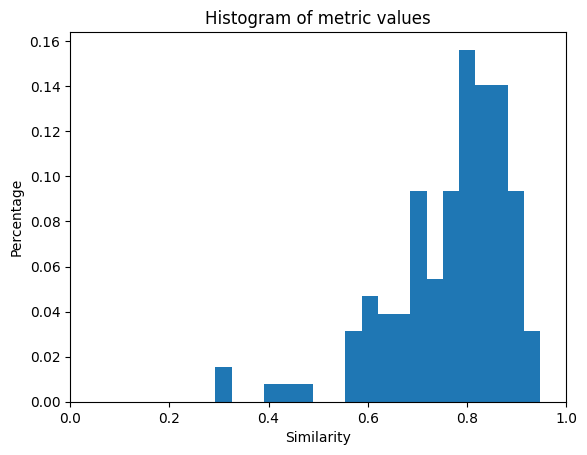

In [5]:
# for a pair of dicts with explanations of 2 models, compute similarity given some metric of every pair of images and return a histogram of similarities
def similarities_for_every_image(explanations1, explanations2, similarity_metric):
    similarities = []
    for e1, e2 in zip(explanations1, explanations2):
        similarities.append(similarity_metric(e1, e2))
    return np.array(similarities)

# plot histogram of dissimilarities
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

def plot_histogram(similarities, bins=20):
    plt.hist(similarities, bins=bins, weights=np.ones(len(similarities)) / len(similarities))
    plt.xlabel('Similarity')
    plt.xlim([0, 1])
    plt.ylabel('Percentage')
    plt.title('Histogram of metric values')
    # plt.xticks(np.round([np.min(similarities), np.max(similarities)], 2))
    # plt.xticks(rotation=90)
    plt.show()

explanations1 = explanations_many_models_g[2]['explanations']
explanations2 = explanations_many_models_g[4]['explanations']
similarities = similarities_for_every_image(explanations1, explanations2, partial(radial_basis_function, sigma=80))
plot_histogram(similarities)

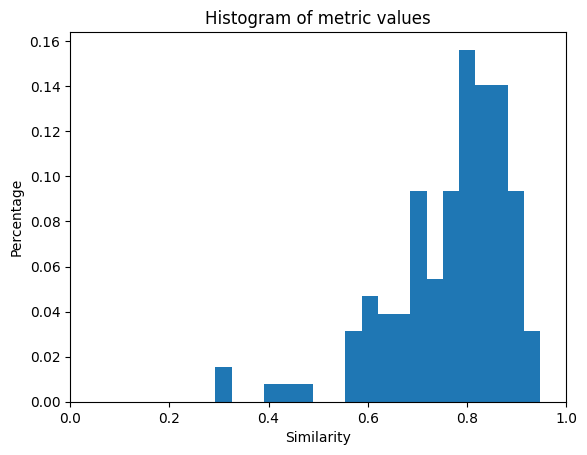

0.23286898084916174 0.12042102496326389
0.26216251733405804


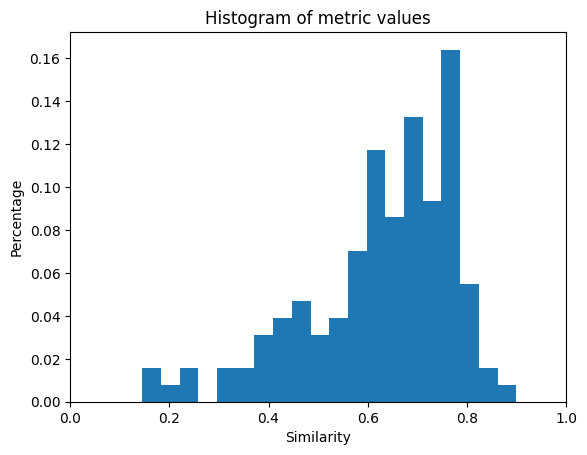

0.3750473614782095 0.15383476747442398
0.4053710140546273


In [6]:
from math import sqrt
similarities = similarities_for_every_image(explanations1, explanations2, partial(radial_basis_function, sigma=80))
plot_histogram(similarities)
print(1-similarities.mean().item(), similarities.std().item())
print(sqrt((1-similarities.mean().item())**2 + similarities.std().item()**2))
similarities = similarities_for_every_image(explanations1, explanations2, cosine_similarity)
plot_histogram(similarities)
print(1-similarities.mean().item(), similarities.std().item())
print(sqrt((1-similarities.mean().item())**2 + similarities.std().item()**2))

In [7]:
np.min(similarities)

0.1451965719461441

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
a = ax.hist([1,1,2,2,2,3])
plt.close()
# print highest and lowest bar
print(a[0].max())
print(a[0].min())

3.0
0.0


In [9]:
# print highest and lowest bar from ax
print(max(ax.patches, key=lambda x: x.get_height()).get_height())
print(min(ax.patches, key=lambda x: x.get_height()).get_height())

3.0
0.0


In [12]:
similarity_name_mapping = {
    'cosine_similarity': 'Cosine similarity',
    'radial_basis_function': 'RBF similarity',
}

# cached_similarities = [[similarities for i in range(len(models_list))] for j in range(len(models_list))]

# create a giant grid of plots of size models x models, where each plot is a histogram of similarities between explanations of 2 models
def plot_all_similarities(explanations_many_models, similarity_metric, bins=25, **kwargs):
    min_similarity = 100000
    max_similarity = -100000
    min_y_value = 100000
    max_y_value = -100000

    n_models = len(explanations_many_models)
    # models_list = list(strings_to_classes_mappings.models_mapping.keys())
    fig, axs = plt.subplots(n_models, n_models, figsize=(10, 10))
    for i in range(n_models):
        for j in range(n_models):
            if i == j:
                # disable ticks, axis but not the labels
                axs[i, j].spines['top'].set_visible(False)
                axs[i, j].spines['right'].set_visible(False)
                axs[i, j].spines['bottom'].set_visible(False)
                axs[i, j].spines['left'].set_visible(False)
                axs[i, j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

                continue
            similarities = similarities_for_every_image(explanations_many_models[i]['explanations'], explanations_many_models[j]['explanations'], partial(similarity_metric, **kwargs))
            # similarities = cached_similarities[i][j]
            min_similarity = min(min_similarity, min(similarities))
            max_similarity = max(max_similarity, max(similarities))
            axs[i, j].hist(similarities, bins=bins, weights=np.ones(len(similarities)) / len(similarities))
            min_y_value = np.min([min_y_value, min(axs[i, j].patches, key=lambda x: x.get_height()).get_height()])
            max_y_value = np.max([max_y_value, max(axs[i, j].patches, key=lambda x: x.get_height()).get_height()])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    
    for i in range(n_models):
        for j in range(n_models):
            axs[i, j].set_xlim(min_similarity, max_similarity)
            axs[i, j].set_ylim(0, max_y_value)

    # set titles for each row and column, rotated 90 degrees
    for i, model in enumerate(models_list):
        axs[i, 0].set_ylabel(model, rotation=0, labelpad=70, fontsize=13)
        axs[n_models - 1, i].set_xlabel(model, rotation=90, fontsize=13)

    # title about the similarity metric
    explanation_name = explanations_many_models[0]['explanation_name']
    explanations_count = len(explanations_many_models[0]['explanations'])
    fig.suptitle(f'Histograms of explanation similarities\nExplanations: {explanation_name}, Metric: {similarity_name_mapping[similarity_metric.__name__]}\nSimilarity - min: {min_similarity:.2f}, max: {max_similarity:.2f}; {explanations_count} images', fontsize=20, y=0.99)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    return fig

## Plot and save

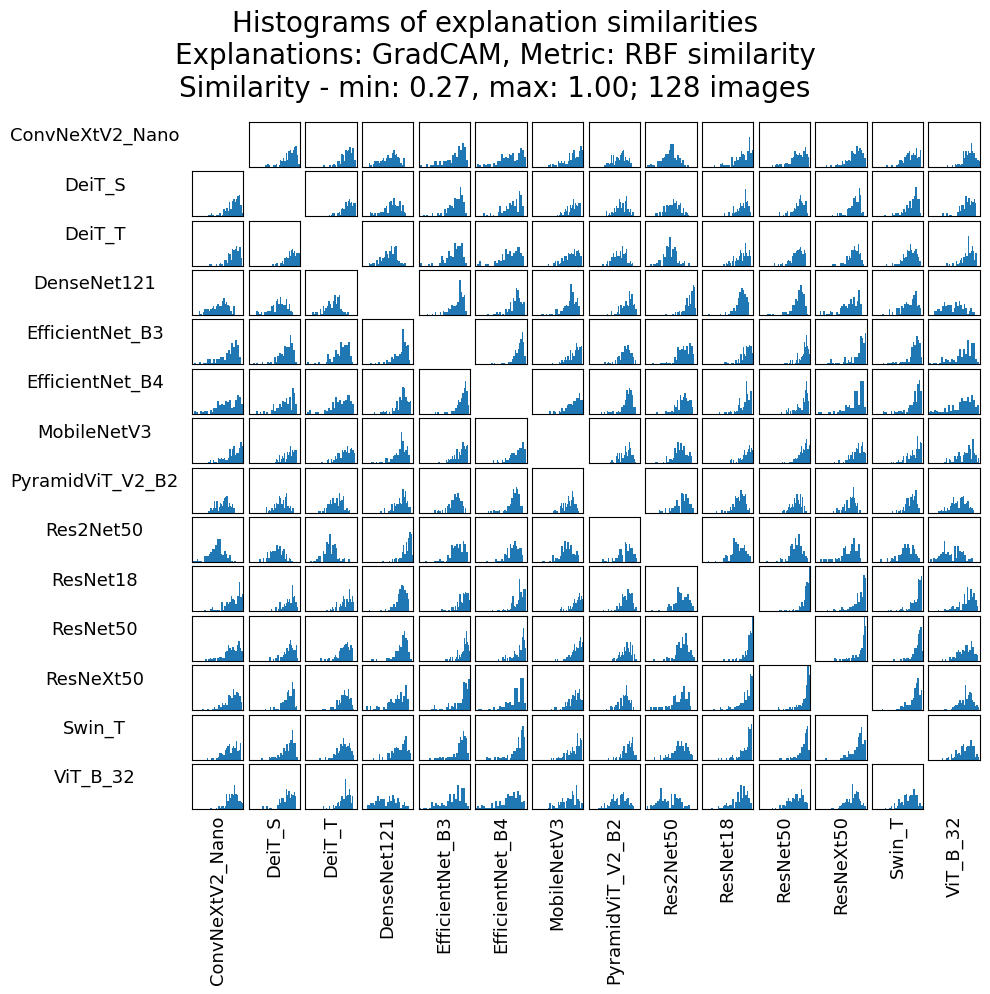

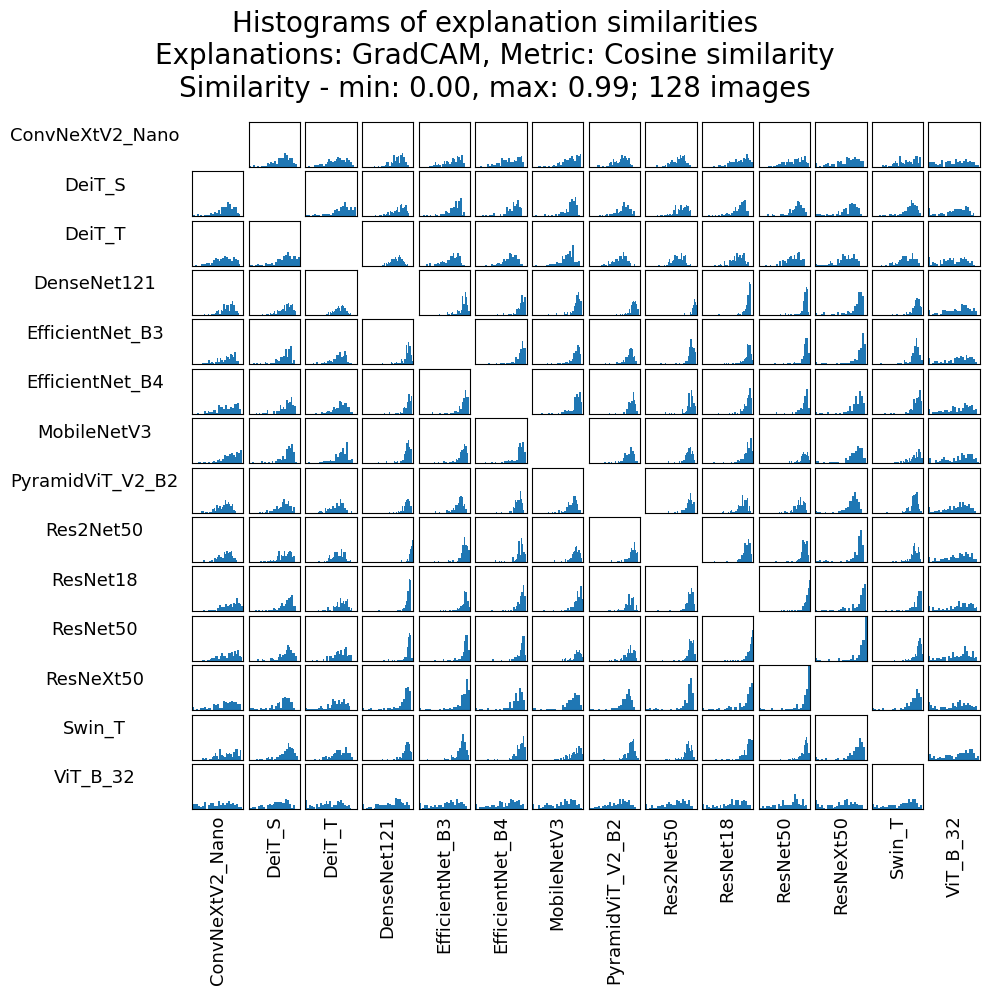

In [13]:
fig = plot_all_similarities(explanations_many_models_g, radial_basis_function, sigma=80)
plt.savefig("histograms_gradcam_rbf.png")
plt.show()
fig = plot_all_similarities(explanations_many_models_g, cosine_similarity)
plt.savefig("histograms_gradcam_cosine.png")
plt.show()

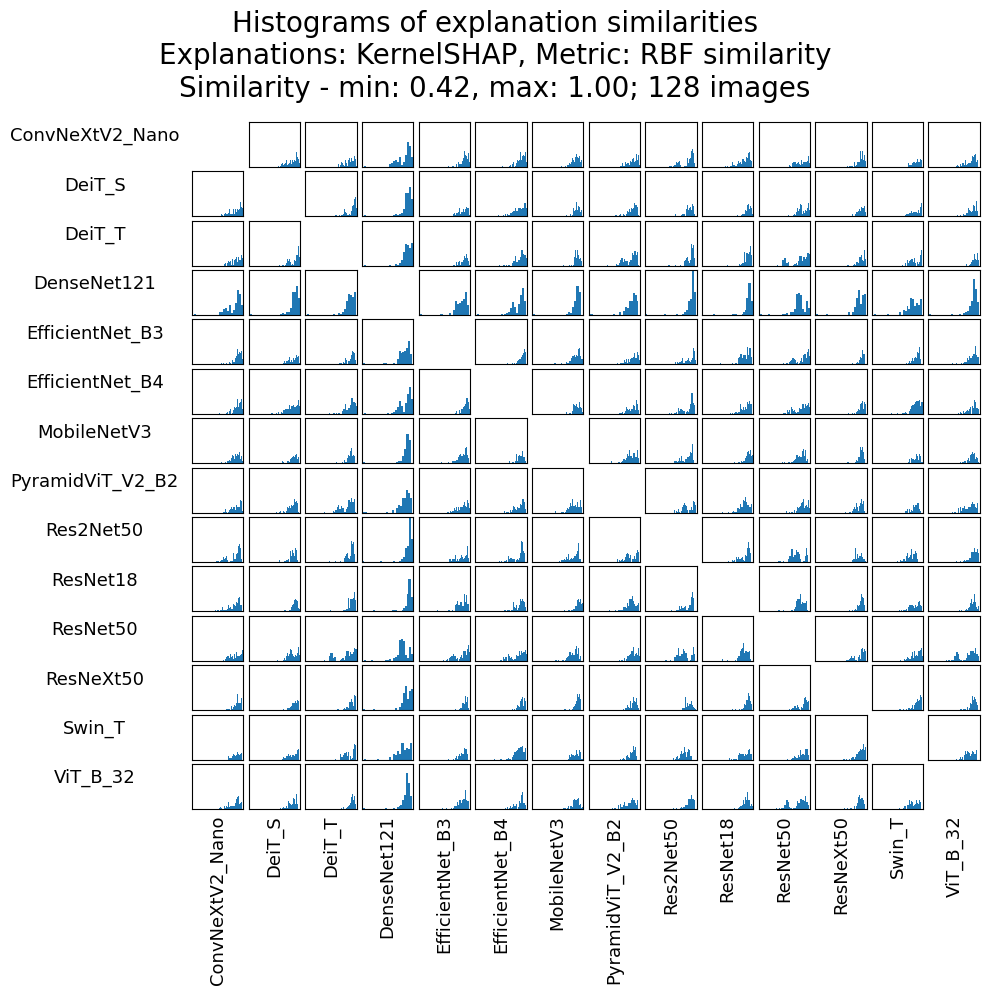

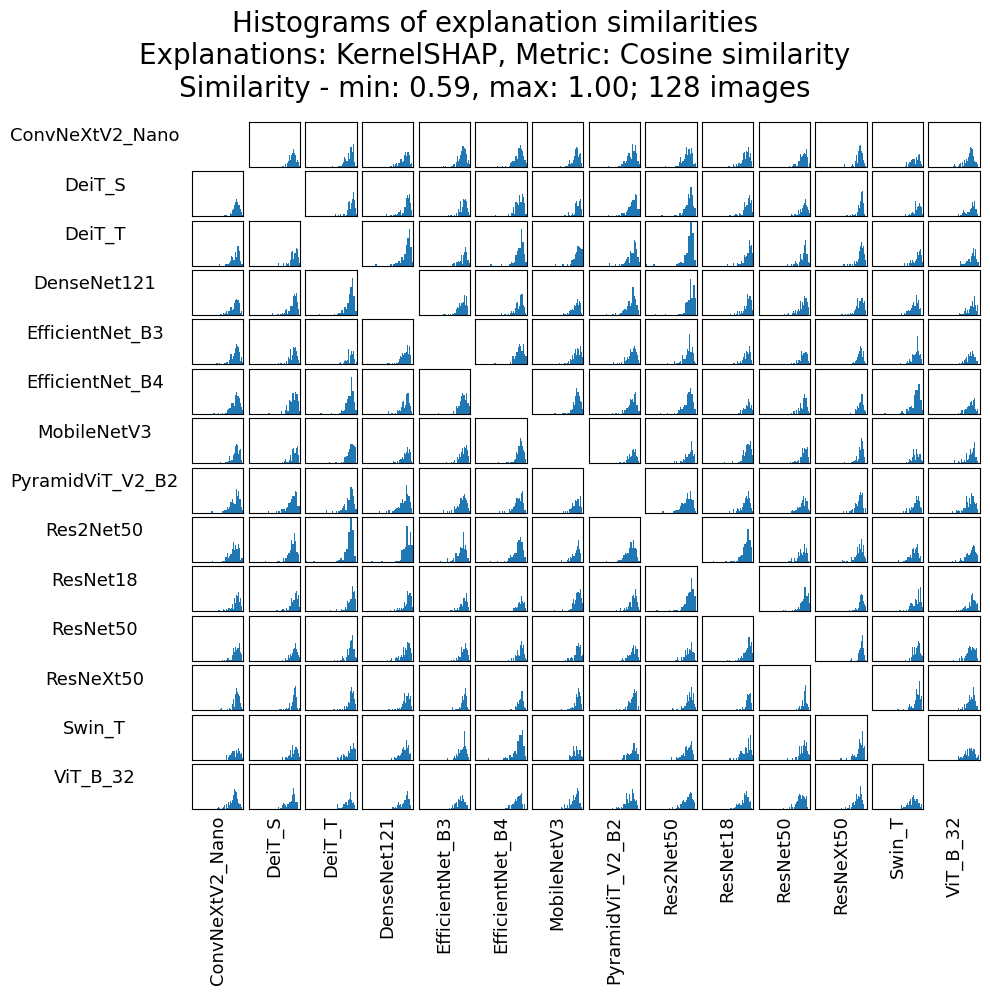

In [14]:
fig = plot_all_similarities(explanations_many_models_k, radial_basis_function, sigma=80)
plt.savefig("histograms_kernelshap_rbf.png")
plt.show()
fig = plot_all_similarities(explanations_many_models_k, cosine_similarity)
plt.savefig("histograms_kernelshap_cosine.png")
plt.show()

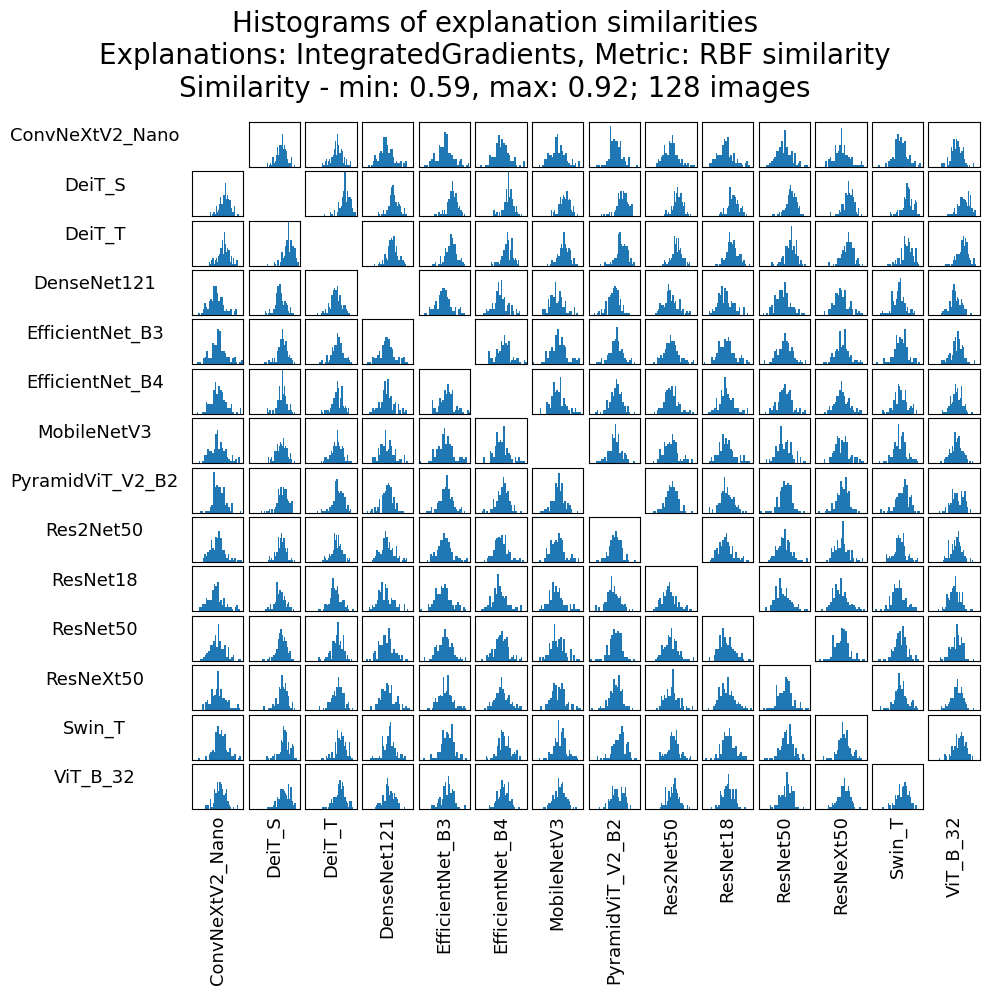

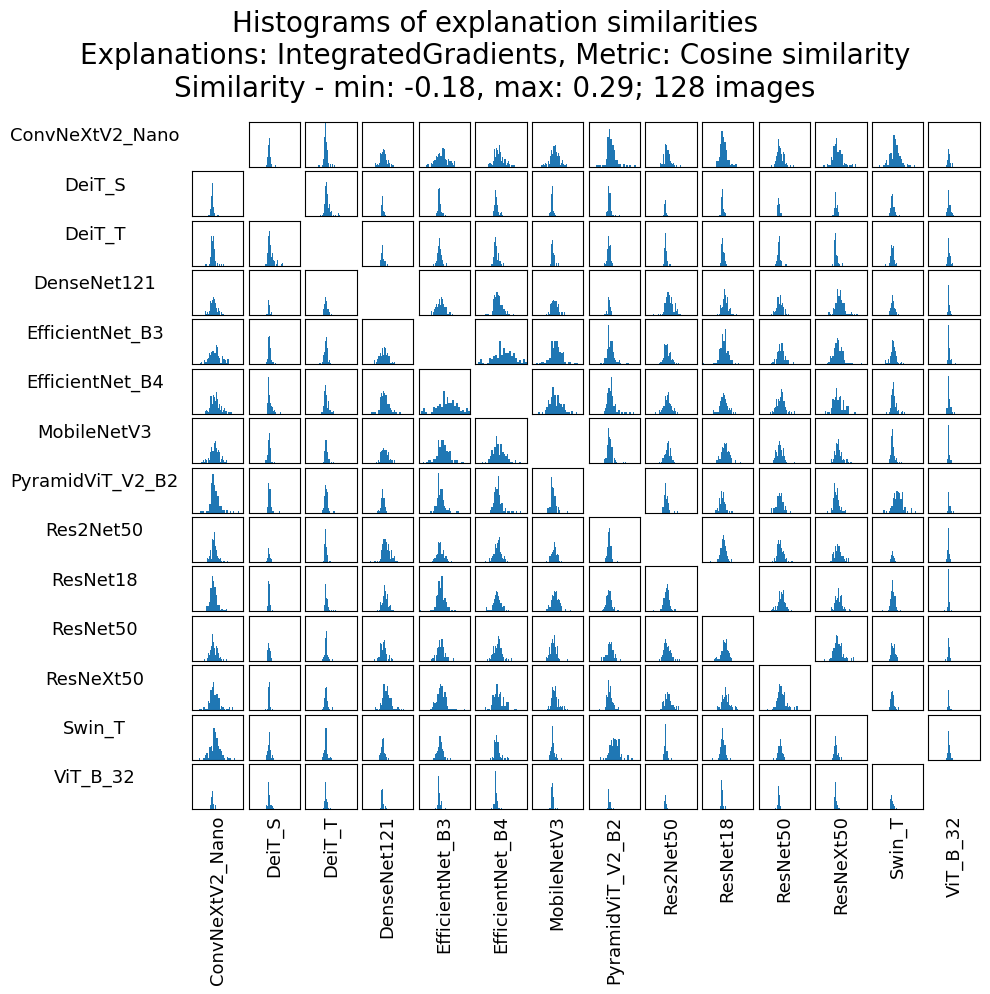

In [15]:
fig = plot_all_similarities(explanations_many_models_i, radial_basis_function, sigma=80)
plt.savefig("histograms_integratedgradients_rbf.png")
plt.show()
fig = plot_all_similarities(explanations_many_models_i, cosine_similarity)
plt.savefig("histograms_integratedgradients_cosine.png")
plt.show()